# [A public data set of spatio-temporal match events in soccer competitions](https://www.nature.com/articles/s41597-019-0247-7)
Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi & Fosca Giannotti

Nature Scientific Data 6, Article number: 236 (2019)

if you use this code or the plots generated from it, please cite/mention the following papers:

- Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7


- Pappalardo, L., Cintia, P., Ferragina, P., Massucco, E., Pedreschi, D., Giannotti, F. (2019) PlayeRank: Data-driven Performance Evaluation and Player Ranking in Soccer via a Machine Learning Approach. ACM Transactions on Intellingent Systems and Technologies 10(5) Article 59, DOI: https://doi.org/10.1145/3343172, https://dl.acm.org/citation.cfm?id=3343172

and the data collection on figshare:

- Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000

## Import library

Here we import all the library useful to create plots.

In [3]:
import json
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import base64
from collections import defaultdict
import sys,os
import math
import random
import operator
import csv
import matplotlib.pylab as pyl
import itertools
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

## Import data sets
Here we import the events data sets, the match data set, the players data set and the competition data set download the the figshare collection (find here the link to download the data: https://www.nature.com/articles/s41597-019-0247-7)

In [4]:
# loading the events data
events={}
nations = ['England','Germany']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
nations = ['England','Germany']
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

## Functions

Here we create all the functions usefull to create the plots.

In [5]:
def pitch():
    """
    code to plot a soccer pitch 
    """
    #create figure
    fig,ax=plt.subplots(figsize=(7,5))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    return fig,ax

In [6]:
def draw_pitch(pitch, line, orientation, view):
    """
    Draw a soccer pitch given the pitch, the orientation, the view and the line
    
    Parameters
    ----------
    pitch
    
    """
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

In [7]:
def in_match_evolution(event_name = 'Goal', event_tag = 101):
    event_time = []
    for nation in nations:
        for ev in events[nation]:
            for i in range(len(ev['tags'])):
                if ev['tags'][i]['id'] == event_tag:
                    event_time.append([ev['matchId'],ev['matchPeriod'],ev['eventSec']])
                else:
                    pass

    df_event = pd.DataFrame(event_time, columns=['matchId','matchPeriod','eventSec'])
    
    f, ax = plt.subplots(figsize=(8,6))
    start_bin_label = 1
    max_bin_count = 0
    for half,color_bar,color_last_bar in zip(['1H','2H'],['b','g'],['skyblue','lightgreen']):
        df_half = df_event[df_event['matchPeriod'] == half].sort_values(['matchPeriod','eventSec'])
        bins = range(0,int(df_half['eventSec'].max())+1)[::300]
        labels = range(start_bin_label,start_bin_label+len(bins)-1)
        df_half['binned'] = pd.cut(df_half['eventSec'], bins=bins, labels=labels)
        df_half = df_half.sort_values('binned')
        barlist = plt.bar(Counter(df_half.binned.dropna()).keys(),Counter(df_half.binned.dropna()).values(),label=half,color=color_bar)
        if len(bins) == 11:
            barlist = barlist[len(bins)-2].set_color(color_last_bar)
        max_bin_half = np.max(list(Counter(df_half.binned.dropna()).values()))
        if max_bin_half > max_bin_count:
            max_bin_count = max_bin_half
        start_bin_label = 12
    plt.legend(fontsize=15,frameon=True,shadow=True)
    plt.xticks(list(range(1,23)),['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','>45','',
                                  '45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','>90'],
              rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(0,max_bin_count+(max_bin_count/100*10))
    plt.xlim(0,22)
    plt.text(10.65,max_bin_count-(max_bin_count/100*10),'half time',rotation=90,bbox=dict(facecolor='w',edgecolor='r'),
             verticalalignment='center',horizontalalignment='left',fontsize=15,color='tomato')
    plt.vlines(11,0,max_bin_count+(max_bin_count/100*10),colors='r',alpha=0.5)
    plt.xlabel('match time (min)', fontsize=25)
    plt.ylabel('%s (n)'%event_name, fontsize=25)
    plt.grid(alpha=0.3)
    f.tight_layout()
    plt.show()

In [8]:
def get_datadriven_weight(position,normalize=True):
    """
    Get the probability of scoring a goal given the position of the field where 
    the event is generated.
    
    Parameters
    ----------
    position: tuple
        the x,y coordinates of the event
        
    normalize: boolean
        if True normalize the weights
    """
    weights=np.array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   8.00000000e+00,   1.10000000e+01,
          1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   4.00000000e+01,   1.28000000e+02,
          7.00000000e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.00000000e+00,   1.01000000e+02,   4.95000000e+02,
          4.83000000e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          6.00000000e+00,   9.80000000e+01,   5.60000000e+02,
          1.12000000e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.00000000e+00,   9.30000000e+01,   5.51000000e+02,
          7.82000000e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   6.70000000e+01,   3.00000000e+02,
          2.30000000e+02],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.30000000e+01,   3.20000000e+01,
          1.10000000e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00]])
    
    x, y = position
    
    if x==100.0:
        x=99.9
    
    if y==100.0:
        y=99.9
    
    w = weights[int(y/10)][int(x/10)]
    
    if normalize: # normalize the weights
        w = w/np.sum(weights)
    return w
    
def get_weight(position):
    """
    Get the probability of scoring a goal given the position of the field where 
    the event is generated.
    
    Parameters
    ----------
    position: tuple
        the x,y coordinates of the event
    """
    x, y = position
    
    # 0.01
    if x >= 65 and x <= 75:
        return 0.01
    
    # 0.5
    if (x > 75 and x <= 85) and (y >= 15 and y <= 85):
        return 0.5
    if x > 85 and (y >= 15 and y <= 25) or (y >= 75 and y <= 85):
        return 0.5
    
    # 0.02
    if x > 75 and (y <= 15 or y >= 85):
        return 0.02
    
    # 1.0
    if x > 85 and (y >= 40 and y <= 60):
        return 1.0
    
    # 0.8
    if x > 85 and (y >= 25 and y <= 40 or y >= 60 and y <= 85):
        return 0.8
    
    return 0.0

In [9]:
def in_window(events_match, time_window):
    start, end = events_match[0], events[-1]
    return start['eventSec'] >= time_window[0] and end['eventSec'] <= time_window[1]

def get_invasion_index(db, match_id, lst=False):
    """
    Compute the invasion index for the input match
    
    Parameters
    ----------
    match_id: int
        the match_id of the match for which we want the invasion index
        
    Returns
    -------
    invasion_index: float
        the invasion index of the two teams, the list of invasion acceleration 
        for each possesion phase of each team
    """
    actions = get_play_actions(db, match_id)
    team2invasion_index = defaultdict(list)
    team2invasion_speed=defaultdict(list)
    events_match = []
    for nation in nations:
        for ev in events[nation]:
            if ev['matchId'] == match_id:
                events_match.append(ev)
    half_offset = {'2H' : max([x['eventSec'] for x in events_match if x['matchPeriod']=='1H']),
                      '1H':0}
    events_match = sorted(events_match, key = lambda x: x['eventSec'] + half_offset[x['matchPeriod']])
    off = half_offset['2H']
    times_all = []
    for action in actions:
        action_type, events_match = action
        offset = off if events_match[0]['matchPeriod']=='2H' else 0
        if len(set([x['matchPeriod'] for x in events_match])) > 1:
            continue
        team_id = events_match[0]['teamId']
        all_weights,times = [],[]
        for event in events_match:
            try:
                x, y, s = int(event['positions'][0]['x']), int(event['positions'][0]['y']), event['eventSec']
            except:
                continue #skip to next event in case of missing position data
            all_weights.append(get_weight((x, y)))
            #all_weights.append(get_datadriven_weight((x, y)))
            times.append(s)

        times_maxinv=sorted(times,key=lambda x:all_weights[times.index(x)],reverse=True)[0]
        seconds=times_maxinv-events_match[0]['eventSec']
        if seconds>0.8:
            team2invasion_speed[team_id]+= [(events_match[0]['eventSec']+offset,(np.max(all_weights)-all_weights[0]) / seconds**2) ]
        
        team2invasion_index[team_id] += [(events_match[0]['eventSec']+offset,np.max(all_weights))]
    
    if not lst:
        team2invasion_index={k:[x for x in v] for k,v in team2invasion_index.items()}
        team2invasion_speed={k:[x for x in v] for k,v in team2invasion_speed.items()}
    
    return team2invasion_index,team2invasion_speed

In [10]:
def segno(x):
    """
    Input:  x, a number
    Return:  1.0  if x>0,
            -1.0  if x<0,
             0.0  if x==0
    """
    if   x  > 0.0: return 1.0
    elif x  < 0.0: return -1.0
    elif x == 0.0: return 0.0

def standard_dev(list):
    ll = len(list)
    m = 1.0 * sum(list)/ll
    return ( sum([(elem-m)**2.0 for elem in list]) / ll )**0.5

def list_check(lista):
    """
    If a list has only one element, return that element. Otherwise return the whole list.
    """
    try:
        e2 = lista[1]
        return lista
    except IndexError:
        return lista[0]
    
def pdf(binsize, input, out='no', normalize=True, include_zeros=False, vmin='NA', vmax='NA',start_from='NA', closing_bin=False):
    """
    Return the probability density function of "input"
    using linear bins of size "binsize"

    Input format: one column of numbers

    Example:
    ---------
      a, m = 0.5, 1.
      data = np.random.pareto(a, 1000) + m
      xy = pdf(10.0, data)
    """
    # Detect input type:
    if input == sys.stdin:
    # the data come form standard input
        d = [ list_check(map(float,l.split())) for l in sys.stdin ]
    #         d = [ float(l) for l in sys.stdin if l.strip() ]
    elif isinstance(input, str):
        # the data come from a file
        d = [ list_check(map(float,l.split())) for l in open(input,'r') ]
    #         d = [ float(w) for w in open(input,'r') if w.split()]
    else:
        # the data are in a list
        try:
            iterator = iter(input)
            d = list(input)
        except TypeError:
            print ("The input is not iterable.")

    bin = 1.0*binsize
    d.sort()
    lend = len(d)
    hist = []
    if out != 'no' and out != 'stdout': f = open(out,'wb')

    j = 0
    if not isinstance(start_from, str):
        i = int(start_from / bin)+ 1.0 * segno(start_from)
    else:
        i = int(d[j] / bin) + 1.0 *segno(d[j])

    while True:
        cont = 0
        average = 0.0
        if i>=0: ii = i-1
        else:   ii = i
        # To include the lower end in the previous bin, substitute "<" with "<="
        while d[j] < bin*(ii+1):
            cont += 1.0
            average += 1.0
            j += 1
            if j == lend: break
        if cont > 0 or include_zeros==True:
            if normalize == True and i != 0:
                hist += [[ bin*(ii)+bin/2.0 , average/(lend*bin) ]]
            elif i != 0:
                hist += [[ bin*(ii)+bin/2.0 , average/bin ]]
        if j == lend: break
        i += 1
    if closing_bin:
        # Add the "closing" bin
        hist += [[ hist[-1][0]+bin , 0.0 ]]
    if out == 'stdout':
        for l in hist:
            print("%s %s" % (l[0],l[1]))
    elif out != 'no':
        for l in hist:
            f.write("%s %s\n" % (l[0],l[1]))
        f.close()
    if out == 'no': return hist

def lbpdf(binsize, input, out='no'):
    """
    Return the probability density function of "input"
    using logarithmic bins of size "binsize"

    Input format: one column of numbers

    Example:
    ---------
      a, m = 0.5, 1.
      data = np.random.pareto(a, 1000) + m
      xy = lbpdf(1.5, data)
    """
    # Detect input type:
    if input == sys.stdin:
    # the data come form standard input
        d = [ list_check(map(float,l.split())) for l in sys.stdin ]
    #         d = [ float(l) for l in sys.stdin if l.strip() ]
    elif isinstance(input, str):
        # the data come from a file
        d = [ list_check(map(float,l.split())) for l in open(input,'r') ]
    #         d = [ float(w) for w in open(input,'r') if w.split()]
    else:
        # the data are in a list
        try:
            iterator = iter(input)
            d = list(input)
        except TypeError:
            print ("The input is not iterable.")

    bin = 1.0*binsize
    d.sort()
    # The following removes elements too close to zero
    while d[0] < 1e-12:
        del(d[0])
    lend = len(d)
    tot = 0
    hist = []

    j = 0
    i = 1.0
    previous = min(d)

    while True:
        cont = 0
        average = 0.0
        next = previous * bin
        # To include the lower end in the previous bin, substitute "<" with "<="
        while d[j] < next:
            cont += 1.0
            average += 1.0
            j += 1
            if j == lend: break
        if cont > 0:
            hist += [[previous+(next-previous)/2.0 , average/(next-previous)]]
            tot += average
        if j == lend: break
        i += 1
        previous = next

    if out != 'no' and out != 'stdout': f = open(out,'wb')
    if out == 'stdout':
        for x,y in hist:
            print("%s %s" % (x,y/tot))
    elif out != 'no':
        f = open(out,'wb')
        for x,y in hist:
            f.write("%s %s\n" % (x,y/tot))
        f.close()
    if out == 'no': return [[x,y/tot] for x,y in hist]

class Parameter:
    def __init__(self, value):
        self.value = value

    def set(self, value):
        self.value = value

    def __call__(self):
        return self.value
    
def LSfit(function, parameters, y, x):
    """
    *** ATTENTION! ***
    *** _x_ and _y_ MUST be NUMPY arrays !!! ***
    *** and use NUMPY FUNCTIONS, e.g. np.exp() and not math.exp() ***

    _function_    ->   Used to calculate the sum of the squares:
                         min   sum( (y - function(x, parameters))**2 )
                       {params}

    _parameters_  ->   List of elements of the Class "Parameter"
    _y_           ->   List of observations:  [ y0, y1, ... ]
    _x_           ->   List of variables:     [ [x0,z0], [x1,z1], ... ]

    Then _function_ must be function of xi=x[0] and zi=x[1]:
        def f(x): return x[0] *  x[1] / mu()

        # Gaussian
            np.exp( -(x-mu())**2.0/sigma()**2.0/2.0)/(2.0*sigma()**2.0*np.pi)**0.5
        # Lognormal
            np.exp( -(np.log(x)-mu())**2.0/sigma()**2.0/2.0)/(2.0*sigma()**2.0*np.pi)**0.5/x

    Example:
        x=[np.random.normal() for i in range(1000)]
        variables,data = map(np.array,zip(*pdf(0.4,x)))

        # giving INITIAL _PARAMETERS_:
        mu     = Parameter(7)
        sigma  = Parameter(3)

        # define your _FUNCTION_:
        def function(x): return np.exp( -(x-mu())**2.0/sigma()**2.0/2.0)/(2.0*sigma()**2.0*np.pi)**0.5

        ######################################################################################
        USA QUESTE FORMULE
        #Gaussian formula
        #np.exp( -(x-mu())**2.0/sigma()**2.0/2.0)/(2.0*np.pi)**0.5/sigma()
        # Lognormal formula
        #np.exp( -(np.log(x)-mu())**2.0/sigma()**2.0/2.0)/(2.0*np.pi)**0.5/x/sigma()
        ######################################################################################


        np.exp( -(x-mu())**2.0/sigma()**2.0/2.0)/(2.0*np.pi)**0.5/sigma()

        # fit! (given that data is an array with the data to fit)
        popt,cov,infodict,mesg,ier,pcov,chi2 = LSfit(function, [mu, sigma], data, variables)
    """
    x = np.array(x)
    y = np.array(y)

    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    p = [param() for param in parameters]
    popt,cov,infodict,mesg,ier = optimize.leastsq(f, p, maxfev=10000, full_output=1) #, warning=True)   #, args=(x, y))

    if (len(y) > len(p)) and cov is not None:
        #s_sq = (f(popt)**2).sum()/(len(y)-len(p))
        s_sq = (infodict['fvec']**2).sum()/(len(y)-len(p))
        pcov = cov * s_sq
    else:
        pcov = float('Inf')

    R2 = 1.0 - (infodict['fvec']**2.0).sum() / standard_dev(y)**2.0 / len(y)

    # Detailed Output: p,cov,infodict,mesg,ier,pcov,R2
    return popt,cov,infodict,mesg,ier,pcov,R2

def maximum_likelihood(function, parameters, data, full_output=True, verbose=True):
    """
    function    ->  callable: Distribution from which data are drawn. Args: (parameters, x)
    parameters  ->  np.array: initial parameters
    data        ->  np.array: Data

    Example:

        m=0.5
        v=0.5
        parameters = numpy.array([m,v])

        data = [random.normalvariate(m,v**0.5) for i in range(1000)]

        def function(p,x): return numpy.exp(-(x-p[0])**2.0/2.0/p[1])/(2.0*numpy.pi*p[1])**0.5

        maximum_likelihood(function, parameters, data)


        # # Check that is consistent with Least Squares when "function" is a gaussian:
        # mm=Parameter(0.1)
        # vv=Parameter(0.1)
        # def func(x): return numpy.exp(-(x-mm())**2.0/2.0/vv())/(2.0*numpy.pi*vv())**0.5
        # x,y = zip(*pdf(0.1,data,out='no'))
        # popt,cov,infodict,mesg,ier,pcov,chi2 = LSfit(func, [mm,vv], y, x)
        # popt
        #
        # # And with the exact M-L values:
        # mm = sum(data)/len(data)
        # vv = standard_dev(data)
        # mm, vv**2.0
    """

    def MLprod(p, data, function):
        return -np.sum(np.array([np.log(function(p,x)) for x in data]))

    return optimize.fmin(MLprod, parameters, args=(data,function), full_output=full_output, disp=verbose)

In [31]:
INTERRUPTION = 5
FOUL = 2
OFFSIDE = 6
DUEL = 1
SHOT = 10
SAVE_ATTEMPT = 91
REFLEXES = 90
TOUCH = 72
DANGEROUS_BALL_LOST = 2001
MISSED_BALL = 1302
PASS = 8
PENALTY = 35
ACCURATE_PASS = 1801

END_OF_GAME_EVENT = {
    u'eventName': -1,
 u'eventSec': 7200,
 u'id': -1,
 u'matchId': -1,
 u'matchPeriod': u'END',
 u'playerId': -1,
 u'positions': [],
 u'subEventName': -1,
 u'tags': [],
 u'teamId': -1
}

START_OF_GAME_EVENT = {
    u'eventName': -2,
 u'eventSec': 0,
 u'id': -2,
 u'matchId': -2,
 u'matchPeriod': u'START',
 u'playerId': -2,
 u'positions': [],
 u'subEventName': -2,
 u'tags': [],
 u'teamId': -2
}

tags_names_df = pd.read_csv('wy_legends/tags2name.csv')
event_names_df = pd.read_csv('wy_legends/eventid2name.csv')
event_names_df.loc[event_names_df.index[-1] + 1] = [-1, -1, 'End of game', 'End of game']

def get_event_name(event):
    event_name = ''
    try:
        if event['subEventName'] != '':
            event_name = event_names_df[(event_names_df.event == event['eventName']) & (event_names_df.subevent == event['subEventName'])].subevent_label.values[0]
        else:
            event_name = event_names_df[event_names_df.event == event['eventName']].event_label.values[0]
    except TypeError:
        #print event
        pass
    
    return event_name

def get_tag_list(event):
    return [tags_names_df[tags_names_df.Tag == tag['id']].Description.values[0] for tag in event['tags']]

def pre_process(events):
    """
    Duels appear in pairs in the streamflow: one event is by a team and the other by
    the opposing team. This can create
    """
    filtered_events, index, prev_event = [], 0, {'teamId': -1}
    
    while index < len(events) - 1:
        current_event, next_event = events_match[index], events_match[index + 1]
        
        # if it is a duel
        if current_event['eventName'] == DUEL: 
            
            if current_event['teamId'] == prev_event['teamId']:
                filtered_events.append(current_event)
            else:
                filtered_events.append(next_event)
            index += 1
            
        else:
            # if it is not a duel, just add the event to the list
            filtered_events.append(current_event)
            prev_event = current_event
            
        index += 1
    return filtered_events

def is_interruption(event, current_half):
    """
    Verify whether or not an event is a game interruption. A game interruption can be due to
    a ball our of the field, a whistle by the referee, a fouls, an offside, the end of the
    first half or the end of the game.
    
    Parameters
    ----------
    event: dict
        a dictionary describing the event
        
    current_half: str
        the current half of the match (1H = first half, 2H == second half)
        
    Returns
    -------
    True is the event is an interruption
    False otherwise
    """
    event_id, match_period = event['eventName'], event['matchPeriod']
    if event_id in [INTERRUPTION, FOUL, OFFSIDE] or match_period != current_half or event_id == -1:
        return True
    return False

def is_pass(event):
    return event['eventName'] == PASS

def is_accurate_pass(event):
    return ACCURATE_PASS in [tag['id'] for tag in event['tags']]

def is_shot(event):
    """
    Verify whether or not the event is a shot. Sometimes, a play action can continue
    after a shot if the team gains again the ball. We account for this case by looking
    at the next events of the game.
    
    Parameters
    ----------
    event: dict
        a dictionary describing the event
        
    Returns
    -------
    True is the event is a shot
    False otherwise
    """
    event_id = event['eventName']
    return event_id == 10
    
def is_save_attempt(event):
    return event['subEventName'] == SAVE_ATTEMPT

def is_reflexes(event):
    return event['subEventName'] == REFLEXES

def is_touch(event):
    return event['subEventName'] == TOUCH

def is_duel(event):
    return event['eventName'] == DUEL

def is_ball_lost(event, previous_event):
    tags = get_tag_list(event)
    #if DANGEROUS_BALL_LOST in tags or MISSED_BALL in tags:
    #    return True
    #if event['eventName'] == PASS:
    #    if 'Not accurate' in tags:
    #        return True
    if event['teamId'] != previous_event['teamId'] and previous_event['teamId'] != -2 and event['eventName'] != 1:
        return True
    
    return False

def is_penalty(event):
    return event['subEventName'] == PENALTY

def get_play_actions(db, match_id, verbose=False):
    """
    Given a list of events occuring during a game, it splits the events
    into play actions using the following principle:
    
    - an action begins when a team gains ball possession
    - an action ends if one of three cases occurs:
    -- there is interruption of the match, due to: 1) end of first half or match; 2) ball 
    out of the field 3) offside 4) foul
    
    """
    try:
            
        events_match = []
        for nation in nations:
            for ev in events[nation]:
                if ev['matchId'] == match_id:
                    events_match.append(ev)
                    
        half_offset = {'2H' : max([x['eventSec'] for x in events_match if x['matchPeriod']=='1H']),
                      '1H':0}
        events_match = sorted(events_match, key = lambda x: x['eventSec'] + half_offset[x['matchPeriod']])
        ## add a fake event representing the start and end of the game
        events_match.insert(0, START_OF_GAME_EVENT)
        events_match.append(END_OF_GAME_EVENT)

        play_actions = []

        time, index, current_action, current_half = 0.0, 1, [], '1H'
        previous_event = events_match[0]
        while index < len(events_match) - 2:

            current_event = events_match[index]

            # if the action stops by an game interruption
            if is_interruption(current_event, current_half):
                current_action.append(current_event)
                play_actions.append(('interruption', current_action))
                current_action = []

            elif is_penalty(current_event):
                next_event = events_match[index + 1]

                if is_save_attempt(next_event) or is_reflexes(next_event):
                    index += 1
                    current_action.append(current_event)
                    current_action.append(next_event)
                    play_actions.append(('penalty', current_action))
                    current_action = []
                else:
                    current_action.append(current_event)

            elif is_shot(current_event):
                next_event = events_match[index + 1]

                if is_interruption(next_event, current_half):
                    index += 1
                    current_action.append(current_event)
                    current_action.append(next_event)
                    play_actions.append(('shot', current_action))
                    current_action = []

                ## IF THERE IS A SAVE ATTEMPT OR REFLEXES; GO TOGETHER
                elif is_save_attempt(next_event) or is_reflexes(next_event):
                    index += 1
                    current_action.append(current_event)
                    current_action.append(next_event)
                    play_actions.append(('shot', current_action))
                    current_action = []

                else:
                    current_action.append(current_event)
                    play_actions.append(('shot', current_action))
                    current_action = []

            elif is_ball_lost(current_event, previous_event):

                current_action.append(current_event)
                play_actions.append(('ball lost', current_action))
                current_action = [current_event]

            else:
                current_action.append(current_event)

            time = current_event['eventSec']
            current_half = current_event['matchPeriod']
            index += 1

            if not is_duel(current_event):
                previous_event = current_event

        events_match.remove(START_OF_GAME_EVENT)
        events_match.remove(END_OF_GAME_EVENT)

        return play_actions
    except TypeError:
        return []

In [32]:
def passing_network(match_Id = 2576105):

    for nation in nations:
        for match in matches[nation]:
            if match['wyId'] == match_Id:
                for competition in competitions:
                    if competition['wyId'] == match['competitionId']:
                        competition_name = competition['area']['name']
                team1_name = match['label'].split('-')[0].split(' ')[0]
                team2_name = match['label'].split('-')[1].split(' ')[1].split(',')[0]
    
    list_ev_match = []
    for ev_match in events[competition_name]:
        if ev_match['matchId'] == match_Id:
            if ev_match['eventName'] == 'Pass':
                list_ev_match.append(ev_match)

    df_ev_match = pd.DataFrame(list_ev_match)
    first_half_max_duration = np.max(df_ev_match[df_ev_match['matchPeriod'] == '1H']['eventSec'])

    #sum 1H time end to all the time in 2H
    for i in list_ev_match:
        if i['matchPeriod'] == '1H':
            i['eventSec'] = i['eventSec']
        else:
            i['eventSec'] += first_half_max_duration
            
    #selected the first team for each team
    team_1_time_player = []
    team_2_time_player = []
    for i in list_ev_match:
        if i['teamId'] == list_ev_match[0]['teamId']:
            team_1_time_player.append([i['playerId'],i['eventSec']])
        else: 
            team_2_time_player.append([i['playerId'],i['eventSec']])


    df_team_1_time_player = pd.DataFrame(team_1_time_player, columns=['sender','eventSec'])
    dict_first_team_1 = [(n, y-x) for n,x,y in zip(df_team_1_time_player.groupby('sender').agg('min').reset_index()['sender'],df_team_1_time_player.groupby('sender').agg('min').reset_index()['eventSec'],df_team_1_time_player.groupby('sender').agg('max').reset_index()['eventSec'])]
    dict_first_team1 = []
    for i in dict_first_team_1:
        if i[1] > 3000:
            dict_first_team1.append(i)
        else:
            pass
    dict_first_team_1 = dict(dict_first_team1)

    df_team_2_time_player = pd.DataFrame(team_2_time_player, columns=['sender','eventSec'])
    dict_first_team_2 = [(n, y-x) for n,x,y in zip(df_team_2_time_player.groupby('sender').agg('min').reset_index()['sender'],df_team_2_time_player.groupby('sender').agg('min').reset_index()['eventSec'],df_team_2_time_player.groupby('sender').agg('max').reset_index()['eventSec'])]
    dict_first_team2 = []
    for i in dict_first_team_2:
        if i[1] > 3000:
            dict_first_team2.append(i)
        else:
            pass
    dict_first_team_2 = dict(dict_first_team2)

    #split pass between team1 and team2
    team_1 = []
    team_2 = []
    for i in list_ev_match:
        if i['teamId'] == list_ev_match[0]['teamId']:
            if i['playerId'] in dict_first_team_1:
                team_1.append(i['playerId'])
            else:
                pass
        else:
            if i['playerId'] in dict_first_team_2:
                team_2.append(i['playerId'])

    df_team_1 = pd.DataFrame(team_1, columns=['sender'])
    df_team_2 = pd.DataFrame(team_2, columns=['sender'])

    #define sender and receiver
    df_team_1 = pd.DataFrame(team_1, columns=['sender'])
    df_team_1['receiver'] = df_team_1['sender'].shift(-1).dropna()
    df_team_2 = pd.DataFrame(team_2, columns=['sender'])
    df_team_2['receiver'] = df_team_2['sender'].shift(-1).dropna()


    #create list with sendere and receiver
    df_team1 = []
    for i,row in df_team_1.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team1.append([row['sender'],row['receiver']])
    df_team1 = pd.DataFrame(df_team1, columns=['sender','receiver'])  
    df_team1_count = df_team1.groupby(['sender','receiver']).size().reset_index(name="Time")

    df_team2 = []
    for i,row in df_team_2.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team2.append([row['sender'],row['receiver']])
    df_team2 = pd.DataFrame(df_team2, columns=['sender','receiver']) 
    df_team2_count = df_team2.groupby(['sender','receiver']).size().reset_index(name="Time")

    list_ev_match = []
    for ev_match in events['Italy']:
        if ev_match['matchId'] == match_Id: #Napoli - Juventus
            if ev_match['eventName'] == 'Pass':
                list_ev_match.append(ev_match)
            else:
                pass
        else:
            pass


    pos1 = {}
    x, y = [], []
    df_match = pd.DataFrame(list_ev_match)
    for player in list(df_team1['sender'].unique()):
        df_match_player = df_match[df_match.playerId==player]
        for i,row in df_match_player.iterrows():
            x.append(row['positions'][0]['x'])
            y.append(row['positions'][0]['y'])

        pos1[int(player)] = (int(np.mean(x)), int(np.mean(y)))

    pos2 = {}
    x, y = [], []
    df_match = pd.DataFrame(list_ev_match)
    for player in list(df_team2['sender'].unique()):
        if player != 8032:
            df_match_player = df_match[df_match.playerId==player]
            for i,row in df_match_player.iterrows():
                x.append(row['positions'][0]['x'])
                y.append(row['positions'][0]['y'])
        else:
            pass

        pos2[int(player)] = (int(np.mean(x)), int(np.mean(y)))

    def merge_two_dicts(x, y):
        z = x.copy()   # start with x's keys and values
        z.update(y)    # modifies z with y's keys and values & returns None
        return z

    pos_all = merge_two_dicts(pos1,pos2)
    
    # networkX team 1

    g = nx.Graph()
    for i,row in df_team1_count.iterrows():
        g.add_edge(row['sender'],row['receiver'],weight=row['Time'])
    nx.draw(g, pos1, with_labels=True, font_weight='bold')
    nx.write_gexf(g, "team_1.gexf")
    print (team1_name)
    print ('centrality =', nx.global_reaching_centrality(g))
    print ('algebric connectivity =', nx.algebraic_connectivity(g))
    print ('density =', nx.density(g))
    print ('')

    g = nx.Graph()
    for i,row in df_team2_count.iterrows():
        g.add_edge(row['sender'],row['receiver'],weight=row['Time'])
    nx.draw(g, pos2, node_color='b', with_labels=True, font_weight='bold')
    nx.write_gexf(g, "team_2.gexf")
    print (team2_name)
    print ('centrality =', nx.global_reaching_centrality(g))
    print ('algebric connectivity =', nx.algebraic_connectivity(g))
    print ('density =', nx.density(g))

    plt.show()

    print ('%s: mean ='%team1_name, df_team1_count.Time.mean()/df_team1_count.Time.sum()*100, '; std =', df_team1_count.Time.std()/df_team1_count.Time.sum()*100, '; count =', df_team1_count.Time.sum())
    print ('%s: mean ='%team2_name, df_team2_count.Time.mean()/df_team2_count.Time.sum()*100, '; std =', df_team2_count.Time.std()/df_team2_count.Time.sum()*100, '; count =', df_team2_count.Time.sum())

In [33]:
def flow_centrality_player(player_wyId = 3359):
    for player in players:
        if player['wyId'] == player_wyId:
            player_name = player['shortName']
            current_team = player['currentTeamId']
            if player['wyId'] == 3322:
                current_team = 675
                
    match_list_current_team = []
    for nation in nations:
        for ev in events[nation]:
            if ev['teamId'] == current_team:
                if ev['matchId'] not in match_list_current_team:
                    match_list_current_team.append(ev['matchId'])
    
    list_match_ev = []
    for nation in nations:
        for ev in events[nation]:
            if ev['matchId'] in match_list_current_team:
                list_match_ev.append(ev)
    
    df_match_ev = pd.DataFrame(list_match_ev)
    
    player_flow_centrality = []
    for match in match_list_current_team:
        df_ev_match = df_match_ev[df_match_ev['matchId']==match]
        df_team = df_ev_match[['playerId','eventSec']].rename(columns={'playerId':'sender'})
        df_team['receiver'] = df_team['sender'].shift(-1).dropna()

        #create list with sendere and receiver
        df_team1 = []
        for i,row in df_team.iterrows():
            if row['sender'] == row['receiver']:
                pass        
            else:
                df_team1.append([row['sender'],row['receiver']])
        df_team1 = pd.DataFrame(df_team1, columns=['sender','receiver'])  
        df_team1_count = df_team1.groupby(['sender','receiver']).size().reset_index(name="Time")

        pos1 = {}
        x, y = [], []

        for player in list(df_team1['sender'].unique()):
            df_match_player = df_ev_match[df_ev_match.playerId==player]
            if df_match_player.shape[0] != 0.:
                for i,row in df_match_player.iterrows():
                    x.append(row['positions'][0]['x'])
                    y.append(row['positions'][0]['y'])

                pos1[int(player)] = (int(np.mean(x)), int(np.mean(y)))
            else:
                pass


        # networkX team 1
        g = nx.Graph()
        for i,row in df_team1_count.iterrows():
            g.add_edge(row['sender'],row['receiver'],weight=row['Time'])
        try:
            player_flow_centrality.append([match,nx.current_flow_betweenness_centrality(g)[player_wyId]])
        except KeyError:
            pass
    
    return player_flow_centrality

In [34]:
def plot_kde_events_on_field(sample_size=10000):
    """
    Generate density plots on the field for each event type
    
    Parameters
    ----------
    sample_size: int
        random sample of values to use (default: 10000). The code becomes slow is you increase this value
        significantly.
    """
    position_ev = []
    for nation in nations:
        for ev in events[nation]:
            position_ev.append([ev['eventName'],ev['positions'][0]['x'],ev['positions'][0]['y']])

    df_pos_ev = pd.DataFrame(position_ev, columns=['eventName','x','y'])

    for event in np.unique(df_pos_ev['eventName']):
        print(event)
        df_pos_event = df_pos_ev[df_pos_ev['eventName'] == event]
        fig,ax = pitch()
        if len(df_pos_event) >= 10000:
            x_y = df_pos_event[['x','y']].sample(sample_size).astype(float)
        else:
            x_y = df_pos_event[['x','y']].astype(float)
        sns.kdeplot(x_y['x'],x_y['y'], cmap = 'Greens', shade = True)
        plt.title(event, fontsize = 30)
        plt.xlim(-1,101)
        plt.ylim(-1,101)
        plt.axis('off')
        fig.tight_layout()
        plt.show()

## Figure 2. Events description

Statistics of the events data set. (a) Frequency of events per type. (b) Distribution of the number of events
in soccer matches. (c) Events produced by the two teams in the match Lazio (cyan points) vs. Internazionale
black squares). The events are plotted on the position of the field where they occurred.

### (a) Percentage of a specific event type
For each event type, we plot how frequent it is in the events data set.

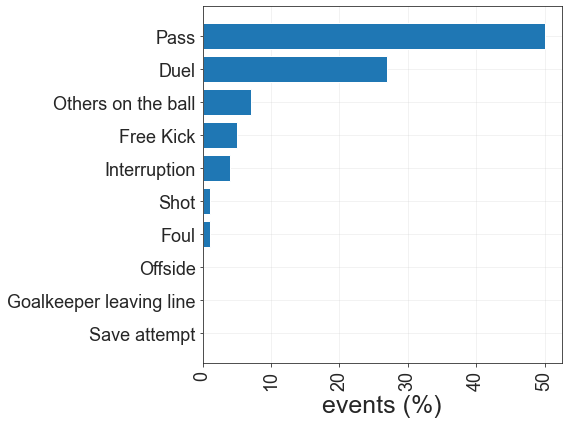

In [35]:
ev_all_nations = []
for nation in nations:
    for i in range(len(events[nation])):
        ev_all_nations.append(events[nation][i]['eventName'])

count = Counter(ev_all_nations)
counter = {}
for i,v in zip(count.keys(),count.values()):
    counter[i] = int(float(v)/len(ev_all_nations)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

#bar plot
f,ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90)
plt.xticks(fontsize=18)
plt.xlabel('events (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
f.tight_layout()
plt.show()

### (b) Distribution of the number of events in soccer matches
We compute the number of events in each match. We then plot the distribution of this quantity.

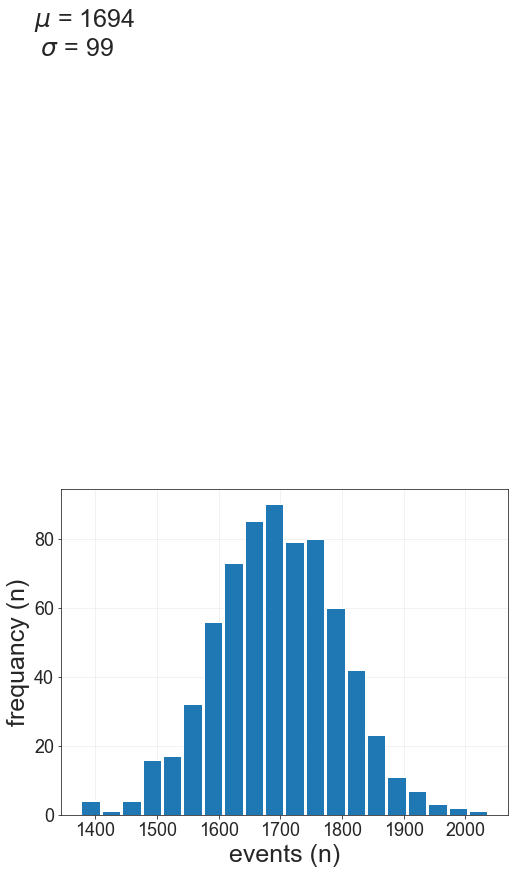

In [36]:
match_ev_count = {}
for nation in nations:
    for ev in events[nation]:
        if ev['matchId'] not in match_ev_count:
            match_ev_count[ev['matchId']] = 1
        else:
            match_ev_count[ev['matchId']] += 1

f,ax = plt.subplots(figsize=(8,6))
plt.hist(list(match_ev_count.values()), rwidth=0.9, bins=20)
plt.grid(alpha=0.3)
plt.yticks(fontsize=18)
plt.ylabel('frequancy (n)', fontsize=25)
plt.xlabel('events (n)', fontsize=25)
plt.xticks(fontsize=18)
plt.text(1300,220, '$\mu$ = %i \n $\sigma$ = %i'%(np.mean(list(match_ev_count.values())), np.std(list(match_ev_count.values()))),fontsize=25)
f.tight_layout()
plt.show()

### (c) Events produced during a match
We take an examplar match and plot on a soccer field all the events of the two teams. Each event is plotted on the position of the field where it has occurred.

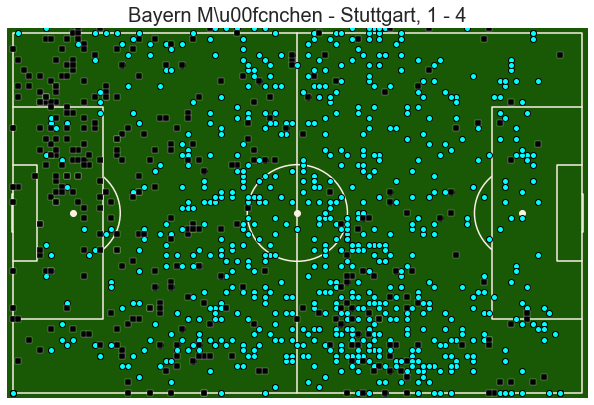

In [37]:
match_id = 2517036
a_match = []
for nation in nations:
    for ev in events[nation]:
        if ev['matchId'] == match_id:
            a_match.append(ev)
            
for nation in nations:
    for match in matches[nation]:
        if match['wyId'] == match_id:
            match_f = match
            
df_a_match = pd.DataFrame(a_match)
team_1, team_2 = np.unique(df_a_match['teamId'])
df_a_match['x'] = [x[0]['x'] for x in df_a_match['positions']]
df_a_match['y'] = [x[0]['y'] for x in df_a_match['positions']]
df_team_1 = df_a_match[df_a_match['teamId'] == team_1]
df_team_2 = df_a_match[df_a_match['teamId'] == team_2]

f = draw_pitch("#195905", "#faf0e6", "h", "full")
plt.scatter(df_team_1['x'], df_team_1['y'], c='cyan', edgecolors="k", zorder=12)
plt.scatter(df_team_2['x'], df_team_2['y'], marker='s', c='k', edgecolors="w", linewidth=0.25, zorder=12)
plt.title(match_f['label'], fontsize=20)
plt.show()

## Figure 3. Events produced by the two teams 

Distribution of positions per event type. Kernel density plots showing the distribution of the events’ positions during match. The darker is the green, the higher is the number of events in a specific field zone.

Duel


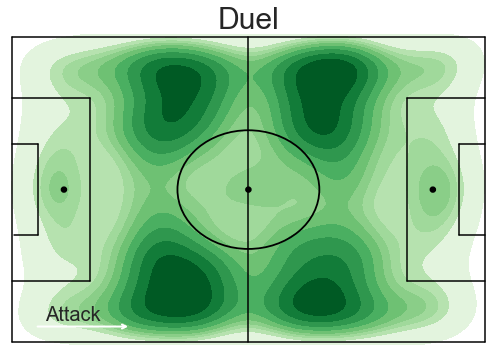

Foul


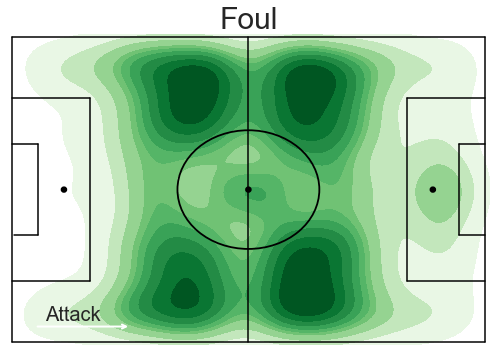

Free Kick


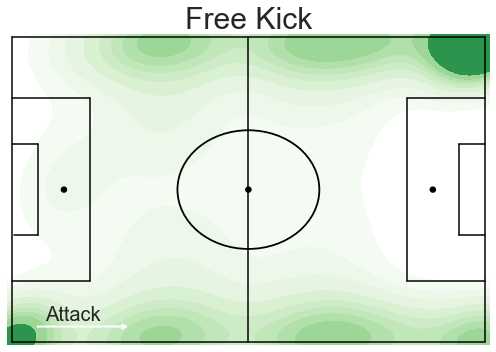

Goalkeeper leaving line


LinAlgError: singular matrix

In [38]:
plot_kde_events_on_field()

## Figure 4. In-match evolution of the number of events

In-match evolution of the number of events. Number of events (e.g., goals on the top plot, yellow cards
in the middle plot and the red cards in the bottom plot) that occur in all the matches in the data set, with time
windows of 5 minutes.

In [ ]:
in_match_evolution(event_name = 'Goal', event_tag = 101)

In [40]:
in_match_evolution(event_name = 'Yellow Card', event_tag = 1702)

ValueError: The number of FixedLocator locations (22), usually from a call to set_ticks, does not match the number of ticklabels (21).

In [ ]:
in_match_evolution(event_name = 'Red Card', event_tag = 1701)

## Figure 5. Invasion index and acceleration index for a game in the match data set

Invasion index and acceleration index for a game in the match data set. Bold lines represent the rolling
mean of, respectively, invasion index (a) and acceleration index (b), while thin lines represent the individual
values computed for each possession phase of each team. Purple vertical lines refer to the two goal scored by
Fiorentina during the match, while the red vertical line indicates the half time of the match.

In [22]:
match_id = 2517036

for nation in nations:
    for ev in events[nation]:
        if ev['matchId'] == match_id:
            a_match.append(ev)
            
df_a_match = pd.DataFrame(a_match)

In [23]:
for nation in nations:
    for match in matches[nation]:
        if match['wyId'] == 2517036:
            match_f = match

In [24]:
match_f['label']

'Bayern M\\u00fcnchen - Stuttgart, 1 - 4'

In [42]:
match_id = 2517036

list_invasion, list_acceleration = get_invasion_index(a_match,match_id,lst=True)

INVASION INDEX
AS Roma 0.328006329113924 0.32701072254320324
ACF Fiorentina 0.23927215189873421 0.30849317655975156

ACCELERATION INDEX
AS Roma 0.06416715290195803 0.15327713026547313
ACF Fiorentina 0.06548080004352279 0.2025414800387677


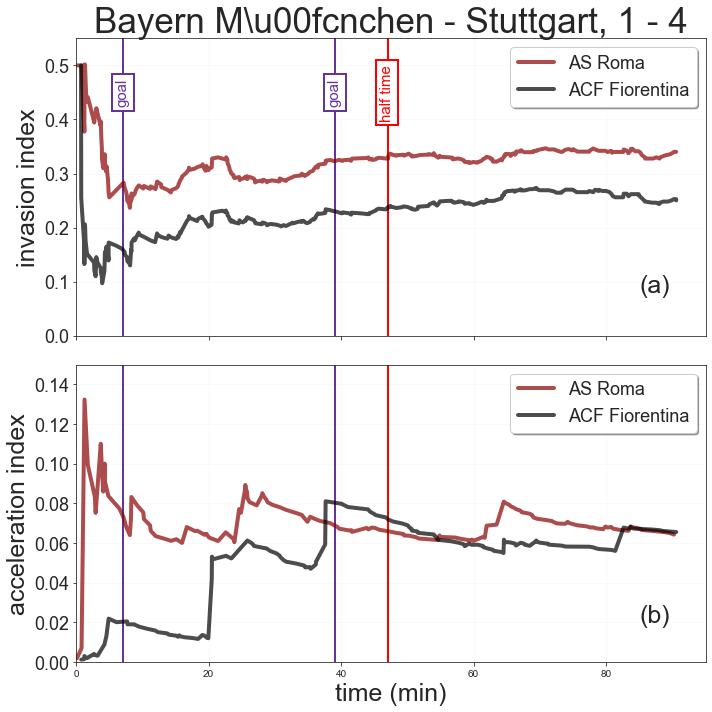

In [68]:
sns.set_style('ticks')

f,ax = plt.subplots(2,1,figsize=(10,10),sharex=True)

print ('INVASION INDEX')
for i,c,label in zip(list(list_invasion),['darkred','k'],['AS Roma','ACF Fiorentina']):
    df_invasion = pd.DataFrame(list_invasion[i],columns=['time','invasion'])
    df_invasion['time'] = [x/60. for x in df_invasion.time]
    print (label, df_invasion['invasion'].mean(), df_invasion['invasion'].std())
    #ax[0].plot(df_invasion.set_index('time'),alpha=0.2,c=c)
    ax[0].plot(df_invasion.set_index('time').rolling(220, min_periods=1).mean(),c=c,alpha=0.7,lw=4,label=label)
ax[0].legend(loc=1,fontsize=18,frameon=True,shadow=True)
ax[0].grid(alpha=0.1)
ax[0].set_ylabel('invasion index',fontsize=25)
ax[0].yaxis.set_tick_params(labelsize=18)
ax[0].text(45.8,0.45,'half time',rotation=90,bbox=dict(facecolor='w',edgecolor='r',lw=2),
         verticalalignment='center',horizontalalignment='left',fontsize=15,color='r')
ax[0].vlines(47,-1,2,colors='r',lw=2)
ax[0].text(6,0.45,'goal',rotation=90,bbox=dict(facecolor='w',edgecolor='rebeccapurple',lw=2),
         verticalalignment='center',horizontalalignment='left',fontsize=15,color='rebeccapurple')
ax[0].vlines(7,-1,2,colors='rebeccapurple',lw=2)
ax[0].text(38,0.45,'goal',rotation=90,bbox=dict(facecolor='w',edgecolor='rebeccapurple',lw=2),
         verticalalignment='center',horizontalalignment='left',fontsize=15,color='rebeccapurple')
ax[0].vlines(39,-1,2,colors='rebeccapurple',lw=2)
ax[0].text(85,0.08,'(a)',fontsize=25)
ax[0].set_ylim(0,0.55)
ax[0].set_title(match_f['label'],fontsize=35)
print ('')

print ('ACCELERATION INDEX')
for i,c,label in zip(list(list_acceleration),['darkred','k'],['AS Roma','ACF Fiorentina']):
    df_acceleration = pd.DataFrame(list_acceleration[i],columns=['time','acceleration'])
    df_acceleration['time'] = [x/60. for x in df_acceleration.time]
    print (label, df_acceleration['acceleration'].mean(), df_acceleration['acceleration'].std())
    #ax[1].plot(df_acceleration.set_index('time'),alpha=0.2,c=c)
    ax[1].plot(df_acceleration.set_index('time').rolling(220, min_periods=1).mean(),c=c,alpha=0.7,lw=4,label=label)
ax[1].legend(fontsize=18,frameon=True,shadow=True,loc=1)
ax[1].grid(alpha=0.1)
ax[1].set_ylabel('acceleration index', fontsize=25)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].text(85,0.02,'(b)',fontsize=25)
ax[1].vlines(47,-1,2,colors='r',lw=2)
plt.xlabel('time (min)',fontsize=25)
from matplotlib.ticker import FormatStrFormatter
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlim(0,95)
# ax[1].text(6,0.45,'goal',rotation=90,bbox=dict(facecolor='w',edgecolor='rebeccapurple',lw=2),
#          verticalalignment='center',horizontalalignment='left',fontsize=15,color='rebeccapurple')
ax[1].vlines(7,-1,2,colors='rebeccapurple',lw=2)
# ax[1].text(38,0.45,'goal',rotation=90,bbox=dict(facecolor='w',edgecolor='rebeccapurple',lw=2),
#          verticalalignment='center',horizontalalignment='left',fontsize=15,color='rebeccapurple')
ax[1].vlines(39,-1,2,colors='rebeccapurple',lw=2)
plt.ylim(0,0.15)
f.tight_layout()

plt.show()

In [58]:
for i,c,label in zip(list(list_acceleration),['darkred','k'],['AS Roma','ACF Fiorentina']):
    df_acceleration = pd.DataFrame(list_acceleration[i],columns=['time','acceleration'])
    df_acceleration['time'] = [x/60. for x in df_acceleration.time]

In [70]:
for i in zip(list(list_acceleration):
    for 

2

In [61]:
df_acceleration.set_index('time').rolling(220, min_periods=1).mean()

,acceleration
time,
0.758875,0.001128
1.191253,0.001306
1.234510,0.002917
1.417834,0.002286
1.632573,0.001866
...,...
84.109215,0.067232
86.943822,0.066732
88.056124,0.066394


In [62]:
df_acceleration.dtypes

time            float64
acceleration    float64
dtype: object

## Figure 6. player passing networks

Representation of the player passing networks of the match Napoli-Juventus. Nodes represent players, edges represent passes between players. The size of the nodes reflects the number of ingoing and outgoing passes (i.e. node’s degree), while the size of the edges is proportional to the number of passes between the players.

The .gexf file extracted from this block could be used to create a pass network by using a Graph Viz Platform.

In [42]:
match_Id = 2576105
for nation in nations:
    for match in matches[nation]:
        if match['wyId'] == match_Id:
            print(match['label'])

Napoli - Juventus, 0 - 1


Napoli
centrality = 0.040000000000000015
algebric connectivity = 19.8886453832748
density = 0.9272727272727272

Juventus
centrality = 0.030000000000000016
algebric connectivity = 14.738652964514955
density = 0.9454545454545454


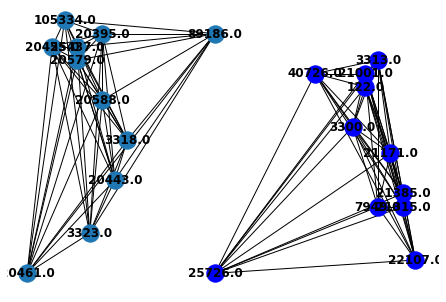

Napoli: mean = 1.0989010989010988 ; std = 0.8392681040140685 ; count = 332
Juventus: mean = 1.0101010101010102 ; std = 0.9275288354647637 ; count = 666


In [43]:
passing_network(match_Id = 2576105)

## Figure 7. Distribution of flow centrality and PlayeRank score for three top players.

Distribution of flow centrality and PlayeRank score for three top players. 

- (a) Distribution of the flow centrality of L. Messi (red line), C. Ronaldo (blue line) e M. Salah (black line) during the soccer season 2017/2018. 
- (b) Performance quality calculated as the PlayeRank score of L. Messi (red line), C. Ronaldo (blue line), and M. Salah (black line).

### Distribution of the flow centrality

In [44]:
Messi_flow_centrality = flow_centrality_player(player_wyId = 3359)

In [45]:
Ronaldo_flow_centrality = flow_centrality_player(player_wyId = 3322)

In [46]:
Salah_flow_centrality = flow_centrality_player(player_wyId = 120353)

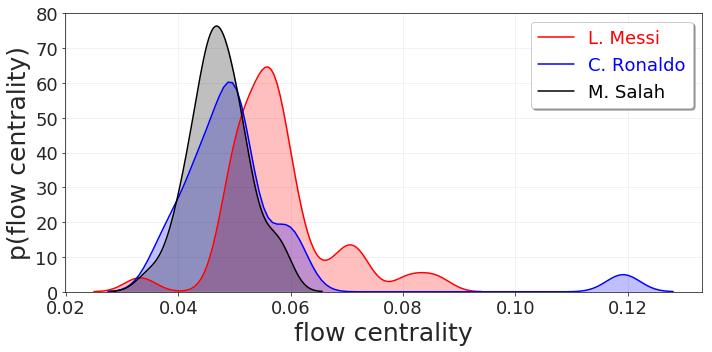

In [47]:
sns.set_style('ticks')

f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(pd.DataFrame(Messi_flow_centrality,columns=['matchId','flow centrality'])['flow centrality'], shade=True, color="r")
sns.kdeplot(pd.DataFrame(Ronaldo_flow_centrality,columns=['matchId','flow centrality'])['flow centrality'], shade=True, color="b")
sns.kdeplot(pd.DataFrame(Salah_flow_centrality,columns=['matchId','flow centrality'])['flow centrality'], shade=True, color="k")
plt.grid(alpha=0.3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('flow centrality', fontsize=25)
plt.ylabel('p(flow centrality)', fontsize=25)
lab = ax.legend(['L. Messi','C. Ronaldo','M. Salah'],loc=1,fontsize=18,frameon=True,shadow=True)
for color,text in zip(['r','b','k'],lab.get_texts()):
    text.set_color(color)
f.tight_layout()
plt.show()

### PlayeRank

In [48]:
df = pd.read_json('cr7-messi-salah.json')

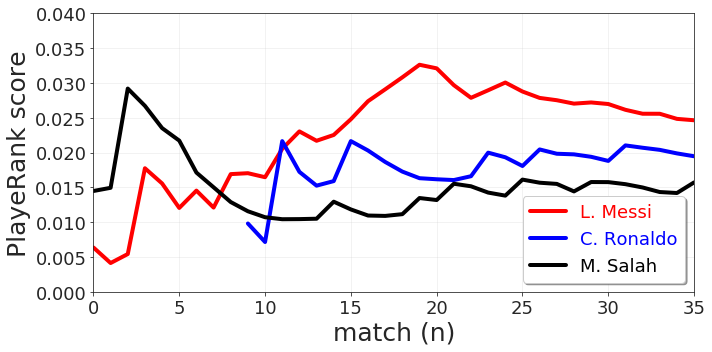

In [49]:
f,ax = plt.subplots(figsize=(10,5),sharex=True)
for player,name,color in zip([u'3359,L. Messi', u'3322,Cristiano Ronaldo', u'120353,Mohamed Salah'],['L. Messi', 'C. Ronaldo', 'M. Salah'],['r','b','k']):
    if player == '3322,Cristiano Ronaldo':
        df_C = df[df.player==player].sort_values('match').reset_index()['playerankScore'].rolling(30, min_periods=1).mean()#.plot(label=player)
        dc = pd.DataFrame([[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan]])
        pd.concat([dc,df_C]).reset_index()[0].plot(label=name,lw=4,c=color)
    else:
        df[df.player==player].sort_values('match').reset_index()['playerankScore'].rolling(50, min_periods=1).mean().plot(label=name,lw=4,c=color)
        
plt.grid(alpha=0.3)
lab = ax.legend(['L. Messi','C. Ronaldo','M. Salah'],loc=4,fontsize=18,frameon=True,shadow=True)
for color,text in zip(['r','b','k'],lab.get_texts()):
    text.set_color(color)
plt.ylim(0,0.04)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('PlayeRank score', fontsize=25)
plt.xlabel('match (n)', fontsize=25)
f.tight_layout()
plt.show()
